In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

true_path1 = '/content/drive/MyDrive/Fakenewsnet/politifact_real.csv'
fake_path1 = '/content/drive/MyDrive/Fakenewsnet/politifact_fake.csv'
true_path2 = '/content/drive/MyDrive/Fakenewsnet/PolitiFact_real_news_content.csv'
fake_path2 = '/content/drive/MyDrive/Fakenewsnet/PolitiFact_fake_news_content.csv'

true_df1 = pd.read_csv(true_path1)
fake_df1 = pd.read_csv(fake_path1)
true_df2 = pd.read_csv(true_path2)
fake_df2 = pd.read_csv(fake_path2)

true_df1['label'] = 1
fake_df1['label'] = 0
true_df2['label'] = 1
fake_df2['label'] = 0
df1 = pd.concat([true_df1, fake_df1])
df2 = pd.concat([true_df2, fake_df2])
df1 = df1[~df1['title'].isna()][['title','label']]
df2 = df2[~df2['title'].isna()][['title','label']]

df = pd.concat([df1, df2])
display(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,label
0,National Federation of Independent Business,1
1,comments in Fayetteville NC,1
2,"Romney makes pitch, hoping to close deal : Ele...",1
3,Democratic Leaders Say House Democrats Are Uni...,1
4,"Budget of the United States Government, FY 2008",1
...,...,...
115,"Donald Trump, Germany’s disfavored son – POLITICO",0
116,BREAKING: Hollywood Legend Just Died Of Terrib...,0
117,Worst. President. Ever.,0
118,Don King drops N-word while introducing Donald...,0


,title,label
0,Press release AIG Discloses Counterparties to ...,1
1,Bureau of Labor Statistics Data,1
2,Hillary Clinton prepares for unpredictable Tru...,0
3,eCFR — Code of Federal Regulations,1
4,Country of Origin Labeling (COOL),1
...,...,...
1291,"Ivanka Trump, Paul Ryan meet",1
1292,Trump Campaign Chair Says Racism Didn’t Exist ...,0
1293,MEXICO’S NEXT PRESIDENT Calls for An Invasion ...,0
1294,U.S. Senator Debbie Stabenow of Michigan,1


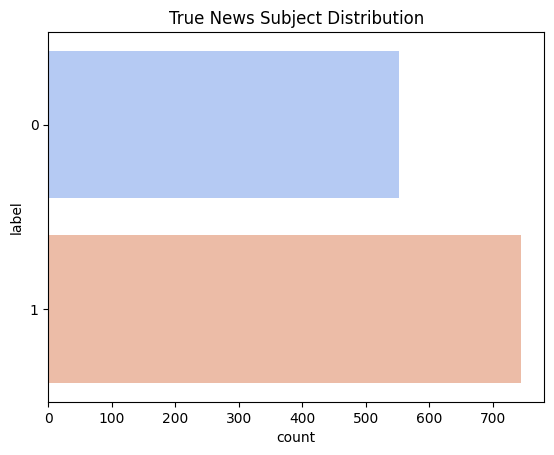

In [2]:
from sklearn.utils import shuffle

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="label", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1296 non-null   object
 1   label   1296 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [4]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 0 to 1295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1097 non-null   object
 1   label   1097 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.7+ KB


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [7]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 1097
Max length of the titles: 35
Mean length of the titles: 7.082953509571559
Median length of the titles: 7.0


In [8]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(df['title'])

sequences = tokenizer.texts_to_sequences(df['title'])
# tokenizer.fit_on_texts(list_of_words)

# sequences = tokenizer.texts_to_sequences(list_of_words)
padded_df = pad_sequences(sequences,maxlen = 30, padding = 'pre', truncating = 'post')


# **LSTM**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
l2_reg = 0.01
optimizer = Adam(lr=0.01)
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=30))
model.add(Dropout(0.3))
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPool1D())
# model.add(Bidirectional(LSTM(100)))
model.add(Bidirectional(LSTM(100, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['label'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


In [11]:
# upsampling and shuffle
import numpy as np
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
x_val, y_val = ros.fit_resample(x_val, y_val)
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)

Epoch 1/5
14/14 [==============================] - 15s 107ms/step - loss: 3.3102 - accuracy: 0.5479 - val_loss: 2.2676 - val_accuracy: 0.7063
Epoch 2/5
14/14 [==============================] - 0s 18ms/step - loss: 1.8182 - accuracy: 0.8446 - val_loss: 1.6778 - val_accuracy: 0.7381
Epoch 3/5
14/14 [==============================] - 0s 16ms/step - loss: 1.0876 - accuracy: 0.9591 - val_loss: 1.4470 - val_accuracy: 0.7857
Epoch 4/5
14/14 [==============================] - 0s 17ms/step - loss: 0.6906 - accuracy: 0.9778 - val_loss: 1.2660 - val_accuracy: 0.7937
Epoch 5/5
14/14 [==============================] - 0s 15ms/step - loss: 0.4411 - accuracy: 0.9965 - val_loss: 1.0514 - val_accuracy: 0.7460


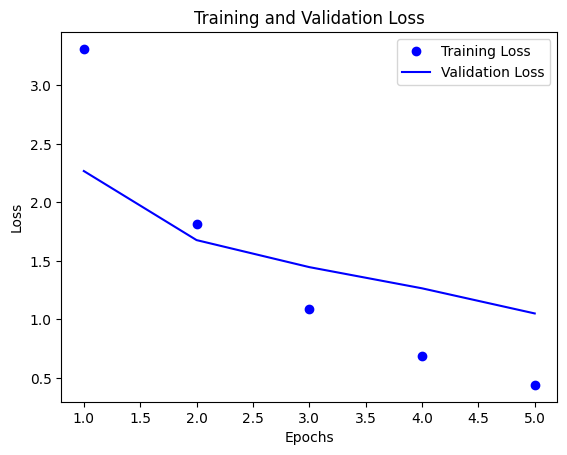

In [12]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 5)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 1s 14ms/step
CNN-BiLSTM Model Accuracy :  0.759090909090909
Precision :  0.782258064516129
Recall :  0.7886178861788617
F1 :  0.7854251012145749
G-mean: 0.7543909404658241
Training time:  15.806367635726929
Inference time:  1.386747121810913
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        97
           1       0.78      0.79      0.79       123

    accuracy                           0.76       220
   macro avg       0.76      0.76      0.76       220
weighted avg       0.76      0.76      0.76       220



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


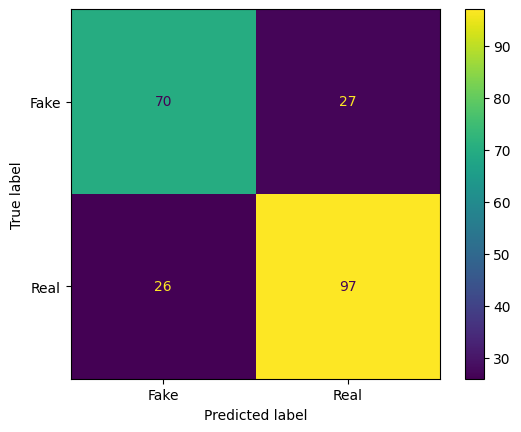

In [13]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()